# "A toy study in gradient descent: polynomial curve fitting"
> "Originally going to be a toy study in Bayesian learning, but I got distracted by a behavior of gradient descent that was surprising to me."

- toc: true 
- badges: true
- comments: true
- categories: [ml, jupyter]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The data

I'll be using a toy dataset based on an example from [Bishop's *Pattern Recognition and Machine Learning*](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book), chapter 1. The data consists of 10 (x, y) points, where x is evenly spaced in [0, 1] and y is generated from $y = \sin(2 \pi x)$ with a small amount of noise.

In [2]:
data = [
    ( 317,  683),
    ( 548,  442),
    ( 779,  353),
    (1010,  371),
    (1241,  792),
    (1473,  775),
    (1704, 1284),
    (1935, 1082),
    (2166, 1141),
    (2397,  727),
]
xdata, ydata = np.transpose(data)
xdata = (xdata - 317) / (2397 - 317)
ydata = (ydata*2 - 357 - 1360) / (357 - 1360)

In [3]:
def plot_curve(f, scatter=True, label=None):
    xx = np.linspace(-0, 1, 200)
    yy = f(xx)
    plt.plot(xx, yy, color='#00ee00', linewidth=1.5, label=label)
    if scatter:
        plt.scatter(xdata, ydata, facecolor='none', edgecolor='#0000ee', linewidth=1.5)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.25, 1.25)
    if label is not None:
        plt.legend()

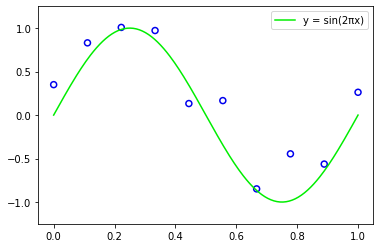

In [4]:
plot_curve(lambda x: np.sin(2*np.pi*x), label='y = sin(2πx)')

## Polynomial fitting

Suppose we'd like to fit this data using a polynomial curve. Since any polynomial is a linear combination of basis functions $[1, x, x^2, ...]$, we can formulate this as an ordinary least squares regression using those basis functions as "features", which has a closed form solution involving a bit of matrix math (the details of which aren't important here, read Bishop if you like).

We can fit a polynomial of any degree up to 9, which is the highest degree polynomial that can be determined by 10 data points. There is naturally a complexity tradeoff: a line is unable to capture the pattern in the data, while a 9th order polynomial is visibly overfit and does not interpolate smoothly between the observed points.

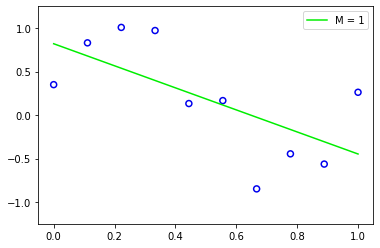

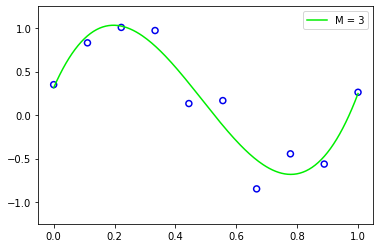

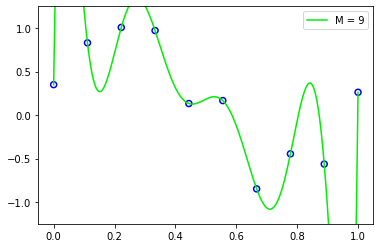

In [5]:
def fit_least_squares_coeffs(order):
    phi = np.array([xdata**i for i in range(order+1)]).T
    return np.linalg.solve(phi.T.dot(phi), phi.T.dot(ydata))

def predict_linear(x, coeffs):
    return np.array([x**i for i in range(coeffs.shape[0])]).T.dot(coeffs)

for M in [1, 3, 9]:
    coeffs = fit_least_squares_coeffs(order=M)
    plt.figure()
    plot_curve(lambda x: predict_linear(x, coeffs), label='M = {}'.format(M))

## Using gradient descent

Now imagine that we've forgotten the math, so instead we'll fit the coefficients using gradient descent. I'll be using PyTorch even though it's overkill for a tiny problem like this.

In [6]:
import torch
import pickle

Define the model, which is a simple if slightly funny looking torch Module. It evaluates each of the basis polynomials on the input `x`, passing the resulting tensor through a linear layer.

In [7]:
class PolynomialCurve(torch.nn.Module):
    def __init__(self, order):
        super().__init__()
        self.M = order
        self.linear = torch.nn.Linear(self.M, 1)

    def forward(self, x):
        phi = torch.cat([x**d for d in range(1, self.M+1)], 1)
        y = self.linear(phi)
        return y

In [8]:
model = PolynomialCurve(order=9)

Even though I'm calling the SGD optimizer, there's nothing stochastic here since I'm passing the whole data in as a batch on every step.

In [9]:
criterion = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [10]:
def train_step(epoch):
    x = torch.autograd.Variable(torch.Tensor(xdata).view(-1, 1))
    y = torch.autograd.Variable(torch.Tensor(ydata).view(-1, 1))

    optimizer.zero_grad()
    y_pred = model(x)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss

Run for `2**24` training steps, saving some model snapshots along the way.

In [11]:
model_states = {}
for epoch in range(2**24):
    loss = train_step(epoch)
    if epoch >= 30 and (epoch+1) & epoch == 0:
        print("epoch {:7d} | loss: {}".format(epoch+1, loss.item()))
        model_states[epoch+1] = pickle.dumps(model.state_dict())

epoch      32 | loss: 0.9128357768058777
epoch      64 | loss: 0.7431008815765381
epoch     128 | loss: 0.6599263548851013
epoch     256 | loss: 0.5450515747070312


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


epoch     512 | loss: 0.4326777160167694
epoch    1024 | loss: 0.3749343454837799
epoch    2048 | loss: 0.36341962218284607
epoch    4096 | loss: 0.3585355281829834
epoch    8192 | loss: 0.35214176774024963
epoch   16384 | loss: 0.3460596203804016
epoch   32768 | loss: 0.34262028336524963
epoch   65536 | loss: 0.3405223786830902
epoch  131072 | loss: 0.3374127745628357
epoch  262144 | loss: 0.33273980021476746
epoch  524288 | loss: 0.3273923397064209
epoch 1048576 | loss: 0.3237205445766449
epoch 2097152 | loss: 0.32257673144340515
epoch 4194304 | loss: 0.3220996856689453
epoch 8388608 | loss: 0.32129746675491333
epoch 16777216 | loss: 0.3200558125972748


Looks like even after millions of steps the loss hasn't converged to zero. Zero loss should be achievable on this problem since we're using a polynomial of order 9 which is capable of perfectly fitting all 10 data points. Let's plot the fits corresponding to the intermediate model states.

In [12]:
def predict(x):
    x = torch.autograd.Variable(torch.Tensor(x).view(-1, 1))
    return model(x).data.numpy()

In [13]:
import matplotlib.animation as animation
from IPython.display import HTML

def show_animation(model_states):
    def animate(epoch):
        model.load_state_dict(pickle.loads(model_states[epoch]))
        plt.cla()
        plot_curve(predict, label='epoch {}'.format(epoch))
    fig = plt.figure()
    ani = animation.FuncAnimation(fig, animate, model_states.keys(), interval=250)
    out = HTML(ani.to_html5_video())
    plt.close()
    return out

In [14]:
show_animation(model_states)

So gradient descent successfully fits the general pattern in the data, but fails to fit the noise and drive the error to zero.

For actual use cases, this is probably even a good thing since fitting noise is bad for generalization.

I was puzzled when I saw this though. Gradient descent doesn't encode a "prior" favoring smooth functions in this context, at least not in an obvious way. And anyway, this problem is all linear and the loss function is a quadratic bowl, so I thought it would be a straightforward case of gradient descent exponentially converging to the optimum. I didn't expect this result.

(A couple days after doing this I stumbled upon this [blog post](https://distill.pub/2017/momentum/) on gradient descent with momentum, which helped me make sense of this thing among others. The whole post is worth a read if you care about this stuff; it certainly changed my view of gradient descent!)

I also tried using Adagrad, and Adam, and different choices of learning rate and momentum parameters. Some converge faster than others, but they all hit a wall at some point where improvement becomes very slow.

## Preconditioning

A potential source of the "problem" is that the basis features $x^i$ are very correlated with each other on [0, 1], so there are some directions along which the coefficients can vary that are not well determined by the data. (I think another way to observe this is that the covariance matrix of the $x^i$'s has some very small eigenvalues.)

We can fix this by changing to a new basis where the features are uncorrelated. There are a few ways to do this, but here I've used the SVD, which is effectively like doing a [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) on the feature vectors before regressing on them. I think it would also be roughly equivalent to use a set of orthogonal polynomials as the basis functions, except here we're making them orthogonal with respect to the distribution of our input x's rather than some standard distribution.

(It wouldn't be feasible to do this directly in a real problem where you'd want to use gradient descent in the first place. But the general idea still applies that normalized uncorrelated data makes gradient descent happier.)

In [15]:
class PolynomialCurvePreconditioned(torch.nn.Module):
    def __init__(self, order, xdata_for_preconditioning):
        super().__init__()
        self.M = order
        self.linear = torch.nn.Linear(self.M, 1)
        # compute SVD for preconditioning
        x = torch.Tensor(xdata_for_preconditioning).view(-1, 1)
        phi = torch.cat([x**d for d in range(1, self.M+1)], dim=1)
        mu = torch.mean(phi, dim=0)
        _u, s, v = torch.svd(phi - mu.expand_as(phi))
        sv_inv = torch.inverse(torch.diag(s).mm(v.transpose(0, 1)))
        self.mu = torch.autograd.Variable(mu, requires_grad=False)
        self.sv_inv = torch.autograd.Variable(sv_inv, requires_grad=False)
        self.s = s

    def forward(self, x):
        phi = torch.cat([x**d for d in range(1, self.M+1)], dim=1)
        u = torch.mm(phi - self.mu.expand_as(phi), self.sv_inv)
        y = self.linear(u)
        return y

For `xdata_for_preconditioning` we'll pass in slightly larger range than the data itself, demonstrating that preconditioning still works even if there is a slight mismatch between these and the actual `xdata`.

In [16]:
model = PolynomialCurvePreconditioned(order=9, xdata_for_preconditioning=np.linspace(-0.05, 1.05, 20))
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [17]:
model_states = {}
for epoch in range(2**16):
    loss = train_step(epoch)
    if epoch > 30 and (epoch+1) & epoch == 0:
        print("epoch {:7d} | loss: {}".format(epoch+1, loss.item()))
        model_states[epoch+1] = pickle.dumps(model.state_dict())

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


epoch      32 | loss: 0.4445711374282837
epoch      64 | loss: 0.33686044812202454
epoch     128 | loss: 0.3211045563220978
epoch     256 | loss: 0.2997950613498688
epoch     512 | loss: 0.2714383006095886
epoch    1024 | loss: 0.23692013323307037
epoch    2048 | loss: 0.1890159696340561
epoch    4096 | loss: 0.12144196778535843
epoch    8192 | loss: 0.05014451593160629
epoch   16384 | loss: 0.008552712388336658
epoch   32768 | loss: 0.0002490167389623821
epoch   65536 | loss: 2.1209997669302538e-07


We now see the loss approaching zero with much fewer training steps. Let's see it:

In [18]:
show_animation(model_states)

For completeness, here's what the orthogonal basis looks like:

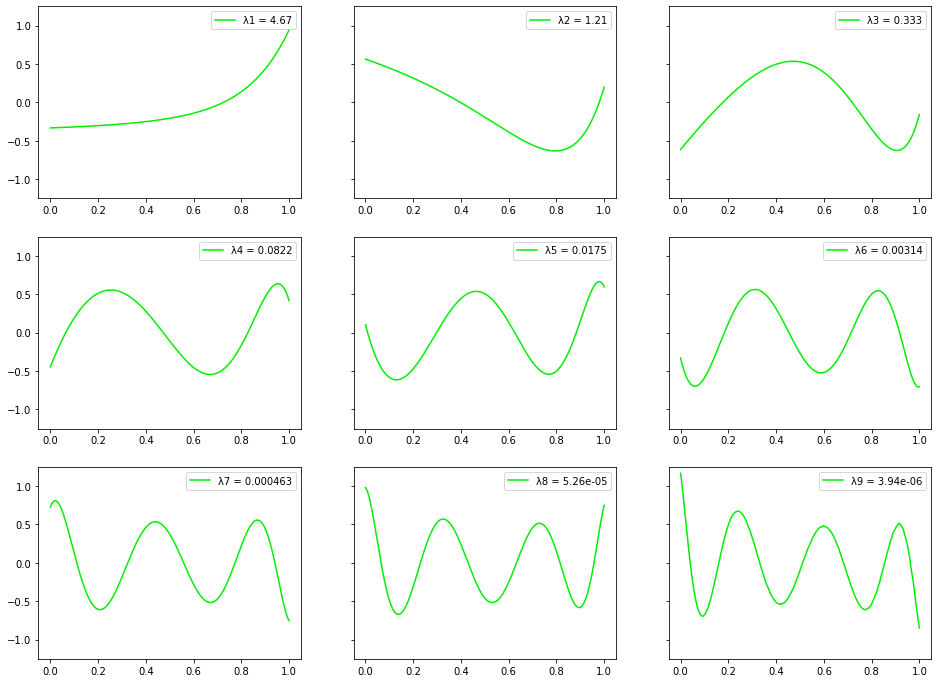

In [19]:
_, axes = plt.subplots(3, 3, sharey=True, figsize=(16, 12))
for i, ax in enumerate(axes.ravel()):
    weight = torch.zeros(1, model.M)
    weight[0, i] = 2.
    model.linear.load_state_dict({'bias': torch.Tensor([0.]), 'weight': weight})
    plt.sca(ax)
    plot_curve(predict, scatter=False, label='λ{} = {:.3g}'.format(i+1, model.s[i]))